In [1]:
# 프로젝트 : Segmentation map으로 도로 이미지 만들기

In [2]:
# 프로젝트 필수 수행사항

# 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요. (어떠한 방법을 사용했는지 적어주세요.)
# 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.
# 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
# 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
# 5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요.

In [3]:
# 필요 라이브러리 가져오기

In [4]:

import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model

In [5]:
# 1. 데이터 준비 및 데이터 가져오기

In [6]:
# 데이터셋 저장 및 압축풀기

In [7]:
# $ mkdir -p ~/aiffel/workspace_lms/03_EXPLORATION_RS5/Quest07/gan
# $ cp ~/aiffel/workspace_lms/03_EXPLORATION_RS5/Quest07/cityscapes.zip ~/aiffel/workspace_lms/03_EXPLORATION_RS5/Quest07/gan
# $ cd ~/aiffel/workspace_lms/03_EXPLORATION_RS5/Quest07/gan && unzip cityscapes.zip

In [8]:
# 데이터 불러오기

In [9]:
import os

train_path = os.getenv('HOME')+'/aiffel/workspace_lms/03_EXPLORATION_RS5/Quest07/gan/cityscapes/train/'
val_path = os.getenv('HOME')+'/aiffel/workspace_lms/03_EXPLORATION_RS5/Quest07/gan/cityscapes/val/'

print("number of train samples :", len(os.listdir(train_path)))
print("number of test samples :", len(os.listdir(val_path)))  

number of train samples : 1000
number of test samples : 5


In [10]:
# train dataset에서 임의의 image(6장) 시각화

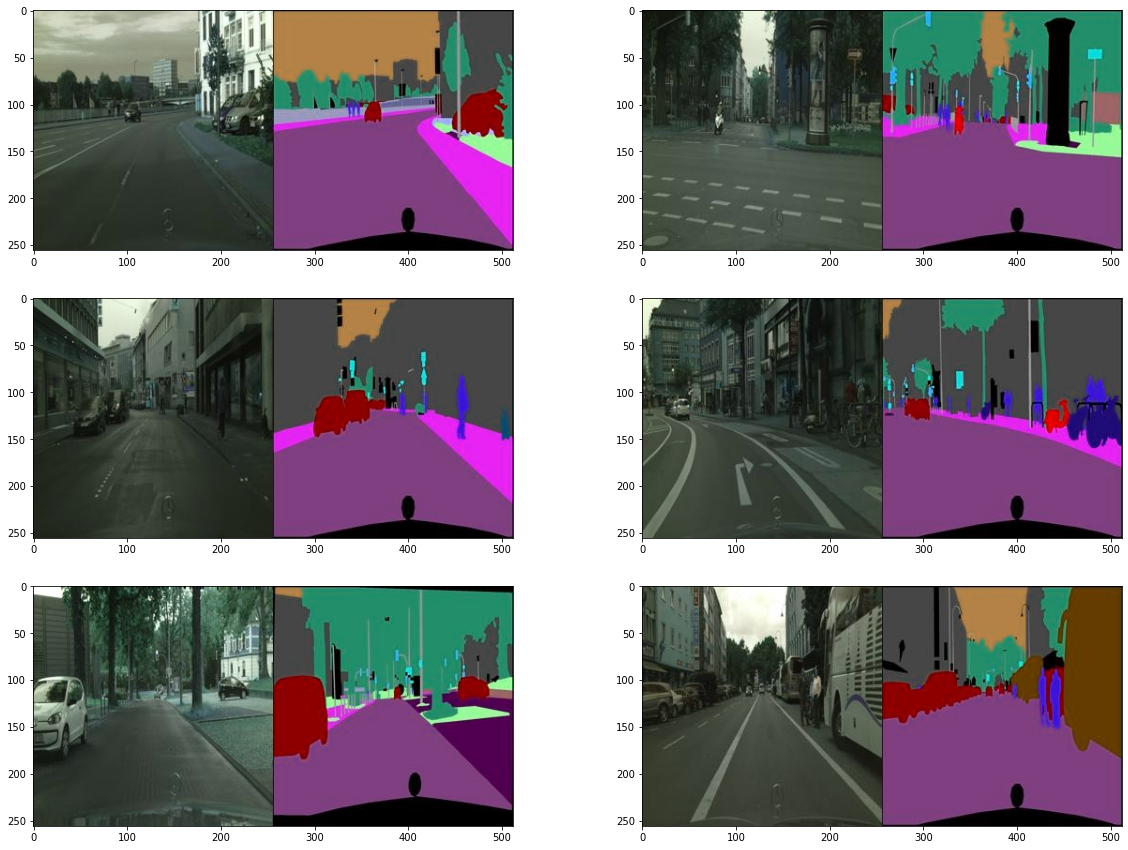

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
# 이미지 size 확인

In [15]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [ ]:
# 이미지 분할(segmented, real)

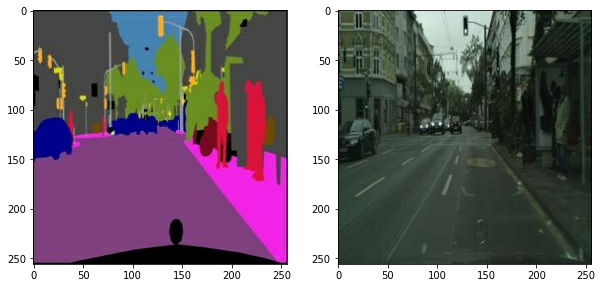

In [6]:
#확인한 이미지 크기를 반으로 나눈 (256, 256, 3) 크기의 2개 이미지 (segmenatation과 실물)로 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1 

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

In [16]:
# Augmentation 적용

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 1. 두 이미지가 채널축으로 연결
    
    _pad = tf.constant([[30,30],[30,30],[0,0]]) # 2. 1의 결과에 각 50% 확률로 reflect padding/constant padding이 30픽셀의 pad width만큼 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT") 
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6]) # 3. 2의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냄
    
    out = image.random_flip_left_right(out) #4. 3의 결과를 50% 확률로 가로로 반전
    out = image.random_flip_up_down(out) #5. 4의 결과를 50% 확률로 세로로 반전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 6. 5.의 결과를 50% 확률로 회전
    
    return out[...,:3], out[...,3:]  

In [17]:
# 아래와 같은 방법으로 augmentation을 적용했습니다.

# 1-1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 
# 1-2. 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
# 2. 1의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
# 3. 2의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
# 4. 3의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
# 5. 4의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
# 6. 5의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

In [18]:
# Augmentation을 적용한 데이터 시각화

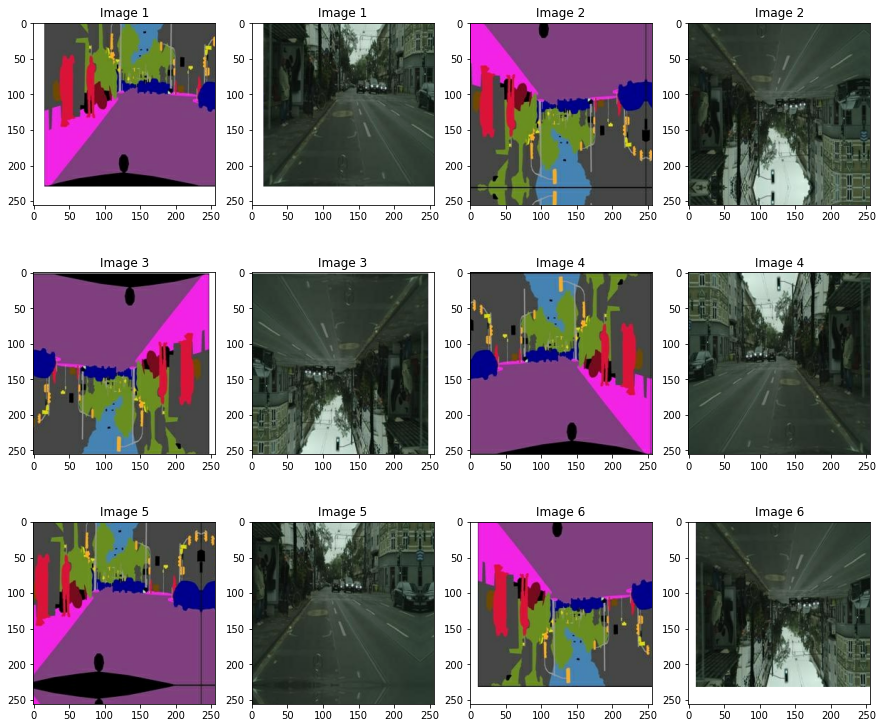

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [ ]:
# 학습데이터에 적용하여 하나의 이미지 시각화

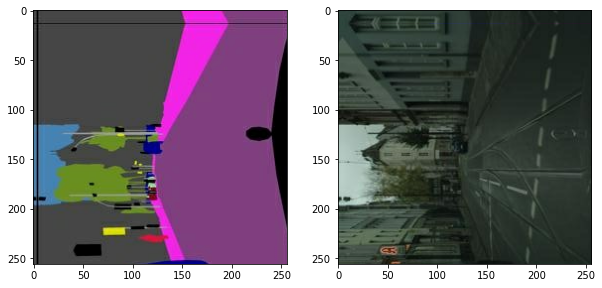

In [9]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [19]:
# 2. Generator 구현하기 (U-Net Generator 사용)

In [20]:
# EncodeBlock 구현

In [21]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [22]:
# DecodeBlock 구현

In [23]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [24]:
# U-Net Generator 구현

In [13]:
class UNetGenerator(Model):
    def __init__(self): #1. __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # 2. Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담음 
        # Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아님
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 3. Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됨
        # Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는 대칭을 이룸
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): # features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결
            x = block(x)
            x = layers.Concatenate()([x, feat]) # layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
generator = UNetGenerator()
generator.get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [25]:
# 3. Discriminator 구현하기

In [26]:
# DiscBlock 구현

In [15]:
class DiscBlock(layers.Layer):
    # __init__() 에서 필요한 만큼 많은 설정을 가능하게 함 
    # 필터의 수(n_filters)
    # 필터가 순회하는 간격(stride)
    # 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad)
    # BatchNorm의 사용 여부(use_bn)
    # 활성화 함수 사용 여부(act)
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D() # 1. width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어남
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
            # 2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듬 (OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1), 채널 수는 사용한 필터 개수와 같음
        
        # 3. 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않음
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [27]:
# Discriminator 구현

In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [17]:
discriminator = Discriminator()
discriminator.get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [28]:
# 모델 작동 확인
# 입력을 넣었을 때 나오는 (30, 30) 출력 시각화

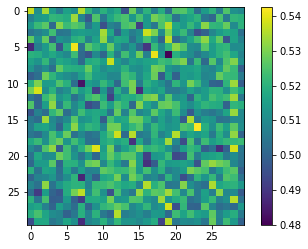

In [18]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [ ]:
# 4. 모델 학습 및 테스트

In [ ]:
# Loss function 정의

In [19]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
# Optimizer 설정

In [20]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
# 학습 과정 구현
# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트

In [21]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

In [29]:
# 함수 사용해 학습 진행 (1 Epoch)

In [22]:
EPOCHS = 1

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 200회 반복마다 손실을 출력
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:2.0967                     
L1_loss:0.2055                     
Discriminator_loss:0.6563



In [30]:
# 학습 결과 확인 및 loss 시각화

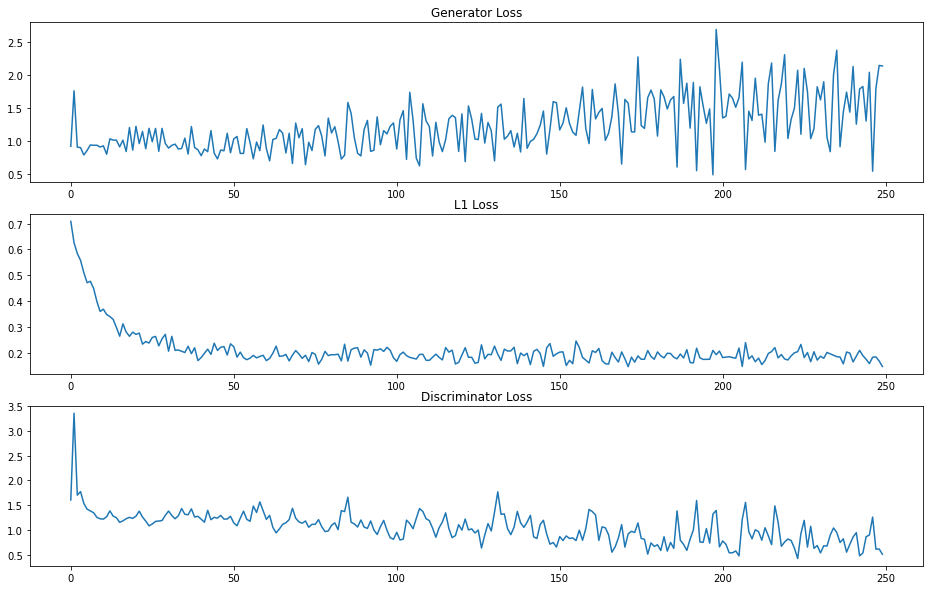

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

In [31]:
# 테스트 진행

In [24]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of train examples :", len(os.listdir(test_path)))

number of train examples : 5


In [32]:
# 도로 이미지 생성

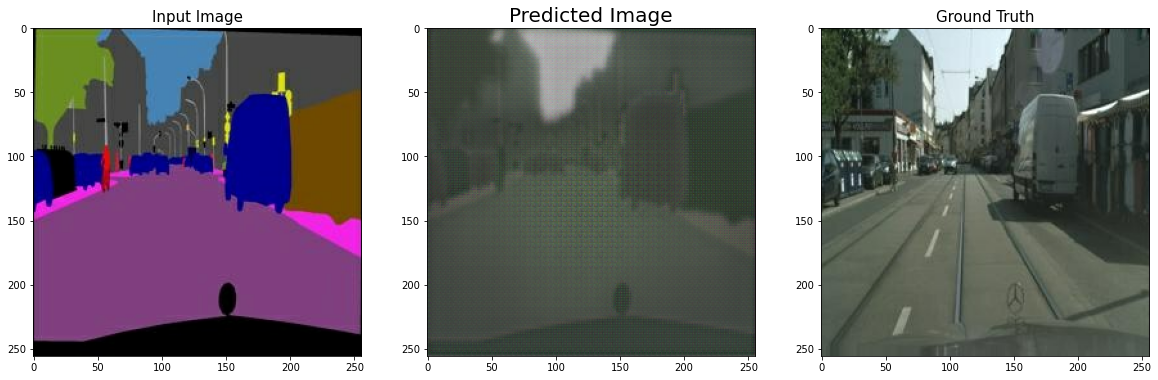

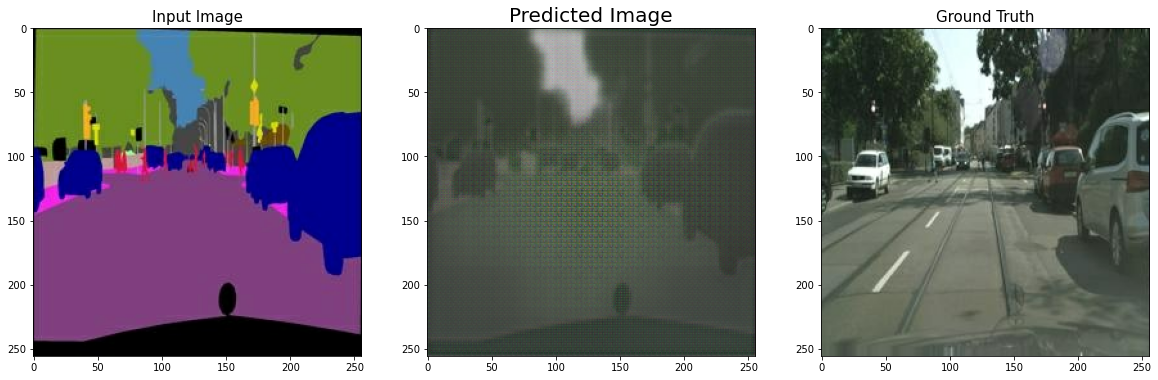

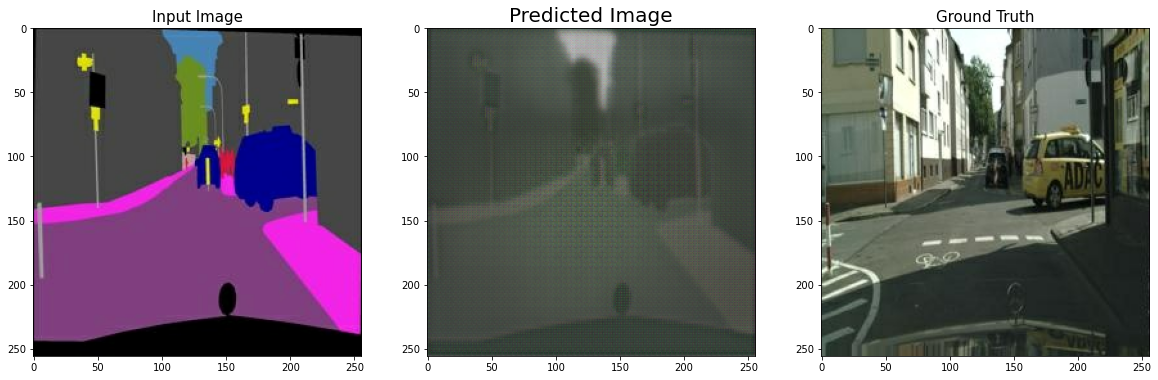

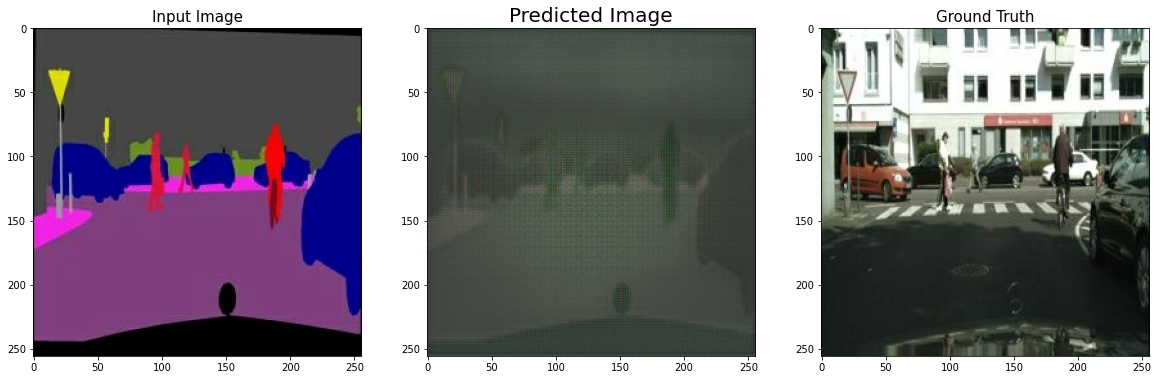

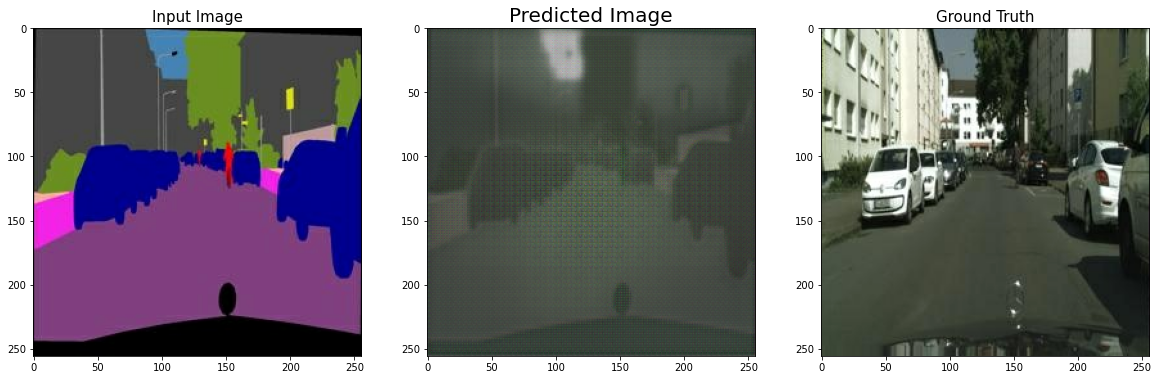

In [25]:
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)

In [33]:
# 가중치 업데이트

In [26]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [34]:
# 학습 진행 (100 Epoch)

In [ ]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.8010                     
L1_loss:0.2261                     
Discriminator_loss:1.2754

EPOCH[1] - STEP[200]                     
Generator_loss:1.3346                     
L1_loss:0.1681                     
Discriminator_loss:0.9577

EPOCH[2] - STEP[100]                     
Generator_loss:2.1135                     
L1_loss:0.1672                     
Discriminator_loss:1.0852

EPOCH[2] - STEP[200]                     
Generator_loss:2.1870                     
L1_loss:0.1702                     
Discriminator_loss:1.1914

EPOCH[3] - STEP[100]                     
Generator_loss:1.8935                     
L1_loss:0.1775                     
Discriminator_loss:1.3763

EPOCH[3] - STEP[200]                     
Generator_loss:1.4221                     
L1_loss:0.1859                     
Discriminator_loss:0.4991

EPOCH[4] - STEP[100]                     
Generator_loss:2.8541                     
L1_loss:0.1803             

In [35]:
# 학습 결과 및 loss 시각화

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

In [ ]:
# 회고

# 전체 흐름을 따라가면서 노드학습 완료와 이해에 초점을 두고 과제를 수행하였습니다.